
# MLP - Visão Guiada em **PyTorch**

Esta é a **versão em PyTorch** do notebook *mlp_visao_guiada*. Mantemos a lógica pedagógica:
- Revisar o ciclo de **forward → loss → backward → step**;
- Mostrar como o **autograd** substitui a derivação manual;
- Comparar os blocos do código manual com suas **contrapartes no PyTorch**;
- Treinar uma MLP simples em dados sintéticos (default) **ou** no dataset BuonoPreço.

> **Ideia-chave**: o que você fazia "na mão" agora é feito pelo framework — mas o **ciclo conceitual é o mesmo**.



## Mapa mental: manual vs PyTorch

| Conceito | Versão manual | Em PyTorch |
|---|---|---|
| Tensor/arranjos | `numpy.ndarray` | `torch.Tensor` (CPU/GPU/MPS) |
| Forward | funções e `np.dot` | `nn.Module.forward` / `nn.Sequential` |
| Loss | função escrita à mão (ex.: BCE) | `nn.BCEWithLogitsLoss` / `nn.CrossEntropyLoss` |
| Gradientes | regras da cadeia manuais | `autograd` (`loss.backward()`) |
| Atualização | `W -= lr * dW` | `optimizer.step()` (SGD/Adam) |
| Mini-batch | laço manual | Mantive o laço, mas passaremos a usar o `DataLoader` |


In [51]:
# === Ambiente e Dispositivo ===
import sys, os, math, random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# CUDA (NVIDIA) -> MPS (Apple Silicon) -> CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device


device(type='mps')


## Definições
- **Sintético (padrão)**: rápido para experimentar.


In [52]:
# === Configurações Gerais ===
SEED = 42
BATCH_SIZE = 64
EPOCHS = 40
LR = 1e-3
HIDDEN = [64, 32]
DROPOUT = 0.1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [54]:
# === Dataset Sintético (binário) ===
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=3000, noise=0.25, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=SEED)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)

train_dl = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(TensorDataset(X_test_t,  y_test_t),  batch_size=BATCH_SIZE, shuffle=False)

X_train_t.shape, y_train_t.shape


(torch.Size([2400, 2]), torch.Size([2400]))


## Modelo (PyTorch)

A MLP em PyTorch é uma classe que herda de `nn.Module`. No `__init__` definimos camadas; no `forward`, o fluxo de dados.


In [55]:
# MLP de 1 camada oculta (equivalente ao W1,b1,W2,b2)
class MLP(nn.Module):
    def __init__(self, n_in, n_hidden, n_out=1, seed=42):
        super().__init__()
        # Inicialização ~ 1/sqrt(fan_in), como no init_params
        g = torch.Generator().manual_seed(seed)
        self.l1 = nn.Linear(n_in, n_hidden)
        with torch.no_grad():
            nn.init.normal_(self.l1.weight, mean=0.0, std=1.0/math.sqrt(n_in), generator=g)
            nn.init.constant_(self.l1.bias, 0.0)

        self.l2 = nn.Linear(n_hidden, n_out)
        with torch.no_grad():
            nn.init.normal_(self.l2.weight, mean=0.0, std=1.0/math.sqrt(n_hidden), generator=g)
            nn.init.constant_(self.l2.bias, 0.0)

        self.act = nn.ReLU()

    def forward(self, x):
        z1 = self.l1(x)
        a1 = self.act(z1)
        z2 = self.l2(a1)  # logit (sem sigmoid aqui; usaremos BCEWithLogitsLoss)
        return z2

## Laço de treinamento


In [56]:
def train_torch(X, y, n_hidden=8, lr=0.1, epochs=100, seed=42, verbose=False):
    """
    Treino "full-batch" para ficar próximo do visão guiada base.
    X: np.ndarray [N, D]
    y: np.ndarray [N] ou [N,1] (binário: 0/1)
    """
    # Tensores
    X_t = torch.tensor(X, dtype=torch.float32, device=device)
    y = y.reshape(-1, 1) if y.ndim == 1 else y
    y_t = torch.tensor(y, dtype=torch.float32, device=device)

    # Modelo
    model = MLP(n_in=X_t.shape[1], n_hidden=n_hidden, n_out=1, seed=seed).to(device)
    
    # Loss: BCE com logits (não aplique sigmoid no forward)
    criterion = nn.BCEWithLogitsLoss()

    # Otimizador: SGD para equivaler ao sgd_step
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    losses = []
    for ep in range(epochs):
        model.train()
        optimizer.zero_grad()

        logits = model(X_t).squeeze(1)
        loss   = criterion(logits, y_t.squeeze(1))

        # autograd calcula gradientes (substitui backward)
        loss.backward()
        # aplica atualização (substitui sgd_step)
        optimizer.step()

        losses.append(loss.detach().cpu().item())

        if verbose and (ep % max(1, epochs//10) == 0):
            print(f"época {ep:4d} | loss={losses[-1]:.6f}")

    return model, np.array(losses)

época    0 | loss=0.768609
época   10 | loss=0.641487
época   20 | loss=0.563226
época   30 | loss=0.505938
época   40 | loss=0.461641
época   50 | loss=0.427184
época   60 | loss=0.400737
época   70 | loss=0.380733
época   80 | loss=0.365822
época   90 | loss=0.354691


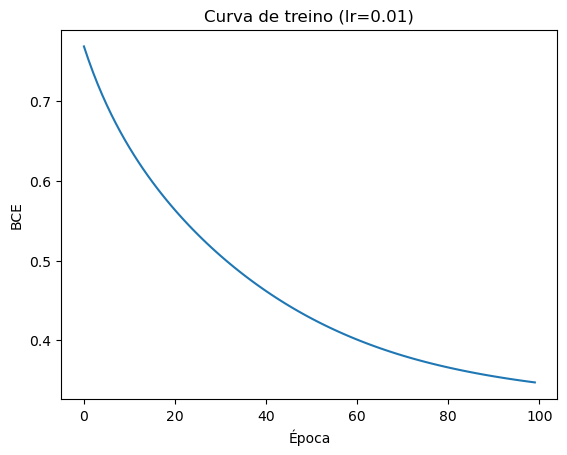

época    0 | loss=0.768609
época   10 | loss=0.641487
época   20 | loss=0.563226
época   30 | loss=0.505938
época   40 | loss=0.461641
época   50 | loss=0.427184
época   60 | loss=0.400737
época   70 | loss=0.380733
época   80 | loss=0.365822
época   90 | loss=0.354691


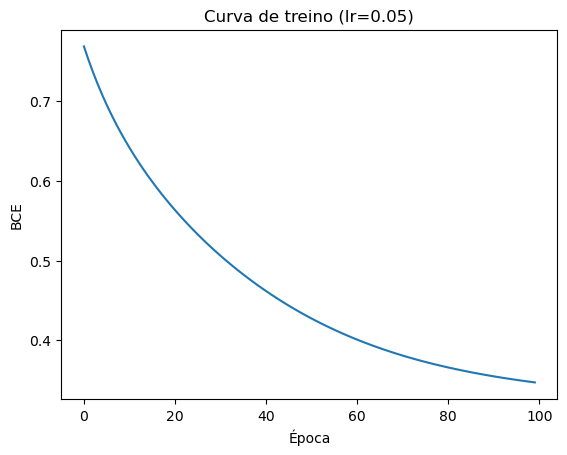

época    0 | loss=0.768609
época   10 | loss=0.641487
época   20 | loss=0.563226
época   30 | loss=0.505938
época   40 | loss=0.461641
época   50 | loss=0.427184
época   60 | loss=0.400737
época   70 | loss=0.380733
época   80 | loss=0.365822
época   90 | loss=0.354691


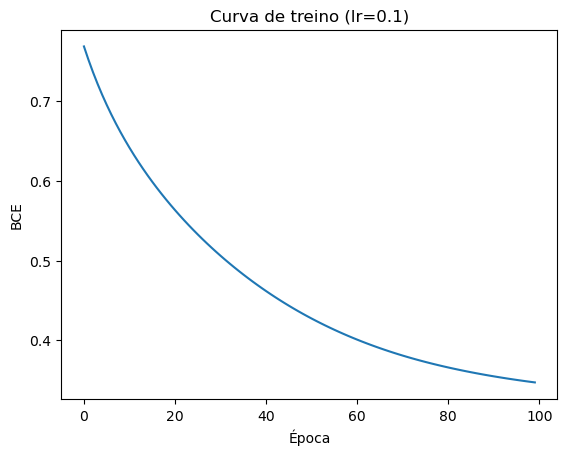

In [57]:
# Treinar com diferentes taxas de aprendizado
import matplotlib.pyplot as plt

for lr in [0.01, 0.05, 0.1]:
    model, losses = train_torch(X, y, n_hidden=8, lr=0.1, epochs=100, verbose=True)
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Época")
    plt.ylabel("BCE")
    plt.title(f"Curva de treino (lr={lr})")
    plt.show()


## Exercícios sugeridos (para fixação)
1. **Troque o otimizador** para `SGD` e compare as curvas.  
2. **Ajuste a arquitetura** (`HIDDEN`, `DROPOUT`) e avalie impacto.  
3. **Troque a loss** para `nn.BCELoss` (com `sigmoid` explícito) e comente as diferenças.  
4. **Salve e carregue** pesos com `torch.save` / `load_state_dict`:

```Python
# === Salvamento do modelo e metadados ===
save_dir = "model/mlp_visao_guiada_pytorch"
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, "mlp_visao_guiada_pytorch_state.pt")
torch.save(model.state_dict(), model_path)

prep_path = os.path.join(save_dir, "prep_stats.npz")
np.savez(prep_path, mu=mu, std=std, in_dim=in_dim, n_classes=n_classes)

print("Salvo:", model_path)
print("Salvo:", prep_path)

```
